In [81]:
using NiLang, NiLang.AD
using LinearAlgebra
using DelimitedFiles
using Plots
using Distributions
include("Adam.jl")

gclip! (generic function with 1 method)

In [82]:
struct Linear{T}
    W1::Matrix{T}
    b1::Vector{T}
    y1::Vector{T}
    y1a::Vector{T}
end
NiLang.AD.GVar(x::Linear) = Linear(GVar(x.W1), GVar(x.b1),GVar(x.y1), GVar(x.y1a));

In [83]:
"""Apply a single linear transformation."""
@i function linear_layer!(x::AbstractVector{T}, layer::Linear{T},y!::AbstractVector{T};method="relu") where T
    @routine @invcheckoff begin
        i_affine!(layer.y1, layer.W1, layer.b1, x)
        end
    
        @inbounds for i=1:length(layer.y1)
            if (method=="relu", ~)
                if (layer.y1[i] >= 0, ~)
                    y![i] += layer.y1[i]
                    layer.y1a[i] += layer.y1[i]
                end
            else
                y![i] += tanh(layer.y1[i])
                layer.y1a[i] +=  tanh(layer.y1[i])
            end
        end
    ~@routine
    ## clean up accumulated rounding error, since this memory is reused.
    @safe layer.y1 .= zero(T)
end

In [84]:
"""Apply a single linear transformation."""
@i function linear_layer!(x::AbstractVector{T}, layer::Linear{T};method="relu") where T
    @routine @invcheckoff begin
        i_affine!(layer.y1, layer.W1, layer.b1, x)
        end
    
        @inbounds for i=1:length(layer.y1)
            if (method=="relu", ~)
                if (layer.y1[i] >= 0, ~)
                    layer.y1a[i] += layer.y1[i]
                end
            else
                layer.y1a[i] +=  tanh(layer.y1[i])
            end
        end
    ~@routine
    @safe layer.y1 .= zero(T)
end

In [85]:
const LinearNetwork{T} = Vector{Linear{T}}


Array{Linear{T},1} where T

In [86]:
@i function Linear_network!(x!::AbstractVector{T}, network::LinearNetwork{T},y!::AbstractVector{T}) where T
    @invcheckoff for i=1:length(network)
        if (i==length(network), ~)
            @inbounds linear_layer!(network[i-1].y1a, network[i], y!,method="tanh")
        else
            if (i==1, ~)
                @inbounds linear_layer!(x!, network[i],method="relu")
            else
                @inbounds linear_layer!(network[i-1].y1a, network[i],method="relu")
            end
        end
    end
end

In [87]:
function random_Linear_network(nparams::Int, nhidden::Int)
    random_Linear_network(Float64, nin, nhidden)
end


random_Linear_network (generic function with 2 methods)

In [88]:
function random_Linear_network(::Type{T}, nin::Int, nhidden::Int) where T
    y1 = zeros(T, nhidden)
    model=Linear{T}[]
    push!(model,Linear{T}(randn(T,  nhidden, nin), randn(T, nhidden),zeros(Float64, nhidden),zeros(Float64, nhidden)))
    push!(model,Linear{T}(randn(T,  nhidden, nhidden), randn(T, nhidden),zeros(Float64, nhidden),zeros(Float64, nhidden)))
    push!(model,Linear{T}(randn(Float64, 1, nhidden), randn(Float64, 1),zeros(Float64, 1),zeros(Float64, 1)))
    return model
end

random_Linear_network (generic function with 2 methods)

In [89]:
x=randn(Float64,1);
model = random_Linear_network(Float64, 1, 64);


In [90]:
y=[0.0]
x,model,y=Linear_network!(x, model,y) 

([0.6232488881408105], Linear{Float64}[Linear{Float64}([-1.8152246488052541; -0.0959262180400028; … ; -1.120062219456915; 0.5668158737989929], [-1.463453340618402, 0.01932280382133191, -0.4472638826247398, 0.06353666798056191, -1.4665411989395245, 1.699661735301573, -0.2396960097794108, 0.6593799062819924, -0.15240831762472856, 0.20277211816719945  …  1.069492746144972, -0.1501777738643446, -1.1005444452283035, 1.0233627362392248, -0.9043350082868544, 0.15837461140806816, 1.391696673876852, -0.20557543498222666, 0.9429227566995791, -0.029792598018800832], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 2.7327731599177065, 1.0638296900464683, 0.3579548184220694, 0.0, 0.8671684514047718  …  0.3671391508834444, 0.027827683101942224, 0.0, 1.1842883268966944, 0.0, 0.7415156475750678, 0.779595942077032, 0.0, 0.24484522377452844, 0.3234747651069834]), Linear{Float64}([0.15355490054071297 1.0441533573042252 … 0.

In [91]:
x,model,y=(~Linear_network!)(x, model,y); 

In [92]:
model

3-element Array{Linear{Float64},1}:
 Linear{Float64}([-1.8152246488052541; -0.0959262180400028; … ; -1.120062219456915; 0.5668158737989929], [-1.463453340618402, 0.01932280382133191, -0.4472638826247398, 0.06353666798056191, -1.4665411989395245, 1.699661735301573, -0.2396960097794108, 0.6593799062819924, -0.15240831762472856, 0.20277211816719945  …  1.069492746144972, -0.1501777738643446, -1.1005444452283035, 1.0233627362392248, -0.9043350082868544, 0.15837461140806816, 1.391696673876852, -0.20557543498222666, 0.9429227566995791, -0.029792598018800832], [0.0, 0.0, 1.1102230246251565e-16, 0.0, -5.551115123125783e-17, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 7.979727989493313e-17, -8.326672684688674e-17, -2.7755575615628914e-17, 0.0, 0.0, -1.734723475976807e-18, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
 Linear{Float64}([0.15355490054071297 1.0441533573042252 … 0.4543685642356038 -1.2583355607383995; -0.39857106953298

In [93]:
nparameters(n::Linear) = length(n.W1) + length(n.b1)
nparameters(n::LinearNetwork) = sum(nparameters, n)

nparameters (generic function with 2 methods)

In [94]:
"""collect parameters in the `layer` into a vector `out`."""
function collect_params!(out, layer::Linear)
    a, b= length(layer.W1), length(layer.b1)
    out[1:a] .= vec(layer.W1)
    out[a+1:a+b] .= layer.b1
    return out
end

collect_params!

In [95]:
function dispatch_params!(layer::Linear, out)
    a, b= length(layer.W1), length(layer.b1)
    vec(layer.W1) .= out[1:a]
    layer.b1 .= out[a+1:a+b]
    return layer
end

dispatch_params! (generic function with 2 methods)

In [96]:
function collect_params(n::LinearNetwork)
    out = zeros(Float64, nparameters(n))
    k = 0
    for layer in n
        np = nparameters(layer)
        collect_params!(view(out, k+1:k+np), layer)
        k += np
    end
    return out
end

collect_params (generic function with 1 method)

In [97]:
function dispatch_params!(network::LinearNetwork, out)
    k = 0
    for layer in network
        np = nparameters(layer)
        dispatch_params!(layer, view(out, k+1:k+np))
        k += np
    end
    return network
end

dispatch_params! (generic function with 2 methods)

In [98]:
struct SineWave
    amplitude::Float32
    phase_shift::Float32
end
SineWave() = SineWave(rand(Uniform(0.1, 5)), rand(Uniform(0, 2pi)))

(s::SineWave)(x::AbstractArray) = s.amplitude .* sin.(x .+ s.phase_shift)

function Base.show(io::IO, s::SineWave)
    print(io, "SineWave(amplitude = ", s.amplitude, ", phase shift = ", s.phase_shift, ")")
end

In [99]:
wave = SineWave(4, 1)


SineWave(amplitude = 4.0, phase shift = 1.0)

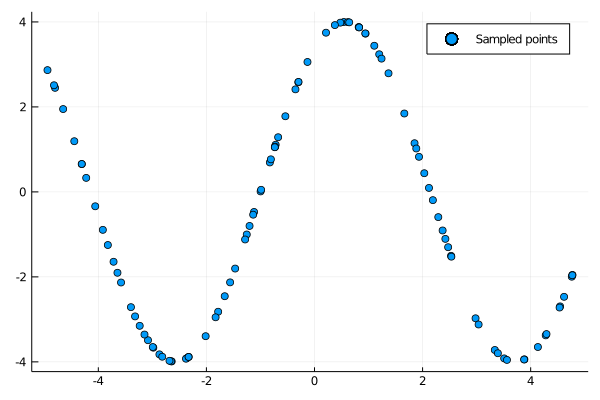

In [100]:
x = rand(Uniform(-5, 5), 100);
y = wave(x);
model = random_Linear_network(Float64, 1, 64);
scatter(x,y,label="Sampled points")

In [101]:
model

3-element Array{Linear{Float64},1}:
 Linear{Float64}([1.4268154789341962; 1.3582238698094584; … ; -1.1368295798757841; -0.0017047136000044214], [-0.5170164958145869, -0.42961830735603845, 0.6239190298393044, -0.33273222985962214, 1.7871997357930949, 0.05259291426801971, -2.2777485800944888, -1.0854187083709324, 0.8993498505177054, -1.1082084350211445  …  -1.78305988631189, -0.12326983969803651, 0.728685182747292, 0.21754747464483198, 0.21578540500663773, 0.37158449229256973, 0.11342855583313473, 0.4438787616092556, -2.1479756153615623, 0.29179739364237406], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
 Linear{Float64}([0.040081407962829996 -0.8741057943651535 … -0.9954613941558377 0.5118397316828821; -1.807934128484342 -0.19759920063495687 … -1.0447988787250362 1.0598757971366333; … ; -0.9965382273035793 0.33714170588624853

In [102]:
@i function loss!(out!::T, x!::AbstractVector{T}, y!::AbstractVector{T},z!::AbstractVector{T},model::LinearNetwork) where T
     for i = 1:length(x!)
        @routine begin
            @zeros T anc1 
            Linear_network!(x[i:i], model,z!)
            anc1 += (z![1]-y![i])^2
            (~Linear_network!)(x[i:i], model,z!) 
        end
        out! += anc1
        ~@routine
        @safe z!.= zero(T)
    end
end

In [103]:
function loss2(out::T, x::AbstractVector{T}, y::AbstractVector{T},model::LinearNetwork) where T
     for i = 1:length(x)
        z=[0.0]
        _,model,z=Linear_network!(x[i:i], model,z)
        out += (z[1]-y[i])^2
        _,model,z=(~Linear_network!)(x[i:i], model,z)
    end
    return out
end

loss2 (generic function with 1 method)

In [104]:
out=0.0;

out=loss2(out, x, y,model);

out

956.283607626004

In [105]:
for i=1:length(model)
    model[i].y1.=0.0;
    model[i].y1a.=0.0;
end

In [106]:
out=0.0;
z=[0.0];

out, x, y,z,model=loss!(out, x, y,z,model);
out

956.283607626004

In [107]:

out, x, y,z,model=(~loss!)(out, x, y,z,model);
out

-5.897504706808832e-13

In [108]:

gout, gx, gy,gz,gmodel= NiLang.AD.Grad(loss!)(out, x, y, z, model;iloss=1)

LoadError: MethodError: no method matching Linear_network!(::Array{Float64,1}, ::Array{Linear{GVar{Float64,Float64}},1}, ::Array{GVar{Float64,Float64},1})
Closest candidates are:
  Linear_network!(::AbstractArray{T,1}, !Matched::Array{Linear{T},1}, !Matched::AbstractArray{T,1}) where T at In[86]:1